In [1]:
import torch
from transformers import AlignProcessor, AlignModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from src.datasets.meme_text_dataloader import get_meme_text_dataloader
from src.utilities import *
from src.models.align_base import align_base



# Load the dataset and the model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else  'cpu')
# Load images into a Dataset, but the pixels will be transformed into list elements, which is not efficient.
meme_loader = get_meme_text_dataloader('memecap', (-1, -1))
# meme_loader.load_datasets(0, 10)
# print(meme_loader.dataset)
# print('meme shape:', np.array(meme_loader.dataset['test']['image'][0]).shape)
# visualize_meme(meme_loader.dataset['test']['image'][0], meme_loader.dataset['test']['caption'][0])
# # TODO (maybe?): Verify if the loading process works well, and if every meme gets resized and cropped correctly.

# load memes and texts
meme_loader.load_datasets(splits=['test']) # test or trainval

Split: test. Length: 559 


# Evaluation
## ALIGN

In [3]:
align_model = align_base()

test_dataset = meme_loader.dataset['test']
# Preprocessing: resize and crop
inputs = align_model.processor(text=test_dataset['caption'], 
                               images=test_dataset['image'], 
                               return_tensors="pt")

In [4]:
from src.evaluation import similarity_align
from src.utilities import recall_at_k
# Calculate the similarity matrix of memes and texts.
text2image_si = similarity_align(inputs, align_model, device)
recall_at_k(text2image_si)

torch.Size([558, 640])
torch.Size([558, 640])


{'r1': 0.5394265232974911,
 'r5': 0.7258064516129032,
 'r10': 0.7741935483870968,
 'r_mean': 0.6798088410991637}

Text(0.5, 1.0, 'The text-meme retrieval probabilities matrix')

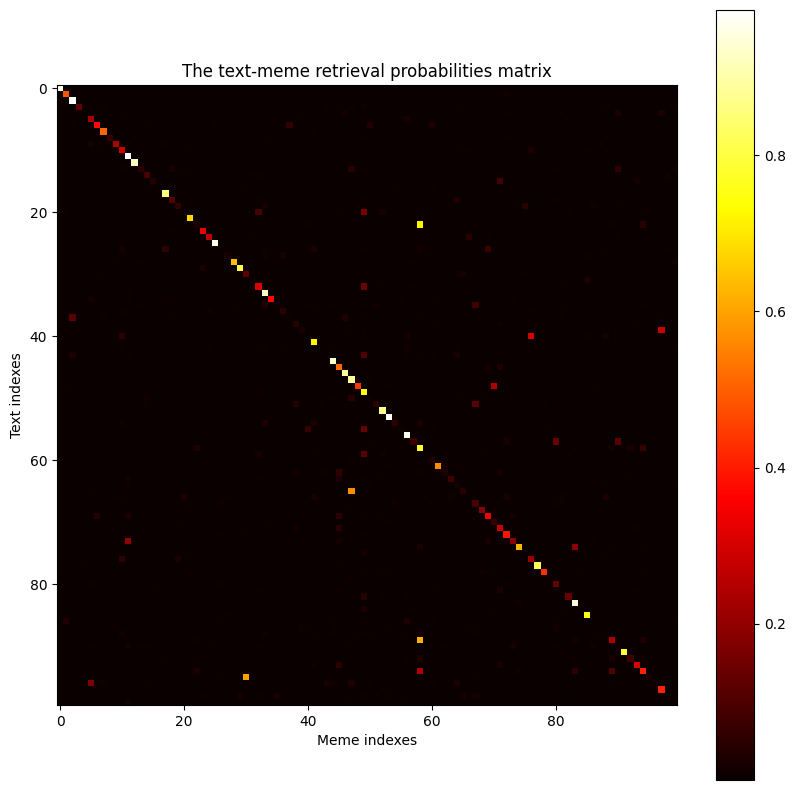

In [6]:
result = text2image_si.softmax(dim=1)[:100, :100]
plt.figure(figsize=(10, 10))
# Plot the tensor as a heatmap
plt.imshow(result, cmap='hot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.ylabel('Text indexes')
plt.xlabel('Meme indexes')
plt.title('The text-meme retrieval probabilities matrix')


## CLIP

In [7]:
from src.models.clip import clip
clip_model = clip()

In [8]:
# Preprocessing: resize and crop
test_dataset = meme_loader.dataset['test']
inputs = clip_model.processor(text=test_dataset['caption'], 
                               images=test_dataset['image'], 
                               return_tensors="pt", 
                               padding=True)

Unused or unrecognized kwargs: padding.


In [9]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [10]:
from src.evaluation import similarity_clip
from src.utilities import recall_at_k
# Calculate the similarity matrix of memes and texts.
text2image_si = similarity_clip(inputs, clip_model, device)
recall_at_k(text2image_si)

torch.Size([558, 512])
torch.Size([558, 512])


{'r1': 0.45698924731182794,
 'r5': 0.6648745519713262,
 'r10': 0.7329749103942652,
 'r_mean': 0.6182795698924731}

Text(0.5, 1.0, 'The text-meme retrieval probabilities matrix')

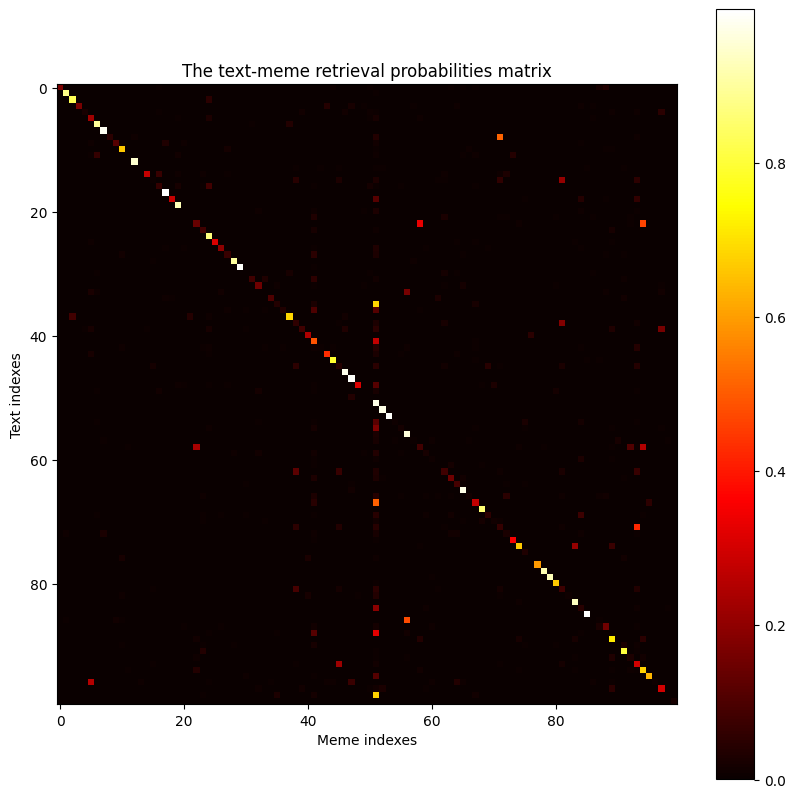

In [11]:
result = text2image_si.softmax(dim=1)[:100, :100]
plt.figure(figsize=(10, 10))
# Plot the tensor as a heatmap
plt.imshow(result[:100, :100], cmap='hot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.ylabel('Text indexes')
plt.xlabel('Meme indexes')
plt.title('The text-meme retrieval probabilities matrix')
